# Image Deconvolution with Regularization

This numerical tour explores the use of
Sobolev and TV regularizations to perform image deconvolution.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
plt.gray()

# seeding the code makes the results reproducible
# change the seed to get new realizations of numpy random variables
np.random.seed(33)

<Figure size 640x480 with 0 Axes>

## The setting

This tour focuses on the deconvolution problem. We have a blurry and noisy measurement:
$$y=\Phi f_0 + w = f_0 \star h + w$$
where $h$ is the filter (low pass) and $w$ white Gaussian noise.

We consider variational deconvolution methods, that look for:
 $$f^\star \in \text{argmin}_f \frac{1}{2}\|y-\Phi f\|^2 + \lambda J(f)$$
where $J(f)$ is a prior energy.

In this tour we will consider a simple L2 prior (the image is assumed to have a bounded energy), a Sobolev prior
(the image is uniformly smooth) and an approximate total variation prior (the
image has edges of bounded perimeter).

Note that the parameter $\lambda$ should be carefully chosen to fit the
noise level.

## Image Blurring

Deconvolution corresponds to removing a blur from an image.
We use here a Gaussian blur.

First we load the image.

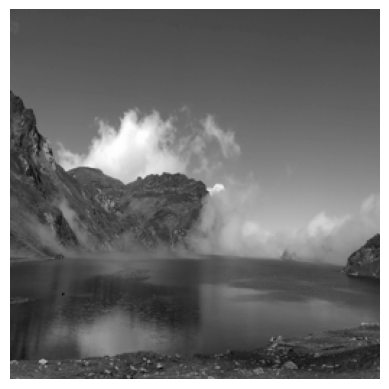

In [2]:
# Download any image you want and put it in the same directory as this script, in the bmp format: 'name_of_image.bmp'
f0 = Image.open('landscape.bmp') # Change the name if needed

n = 256
f0 = f0.resize((n, n)) # Resize image

f0 = f0.convert('L') # Image to grayscale
f0 = np.array(f0) # Convert to numpy array
f0 = f0 / f0.max() # Values are now in [0, 1]

plt.axis('off')
plt.imshow(f0); # Display image

We build a convolution kernel.
Since we are going to use Fourier to compute the convolution,
we set the center of the kernel in the (1,1) pixel location.

In [3]:
# Grid
x = np.concatenate((np.arange(0, n // 2), np.arange(-n // 2, 0)))
[Y, X] = np.meshgrid(x, x)

print('X = ', X)
print('Y = ', Y)

# Kernel h
s = 3
h = np.exp((-X ** 2 -Y ** 2) / (2 * s ** 2))
h /= sum(h.flatten())

X =  [[ 0  0  0 ...  0  0  0]
 [ 1  1  1 ...  1  1  1]
 [ 2  2  2 ...  2  2  2]
 ...
 [-3 -3 -3 ... -3 -3 -3]
 [-2 -2 -2 ... -2 -2 -2]
 [-1 -1 -1 ... -1 -1 -1]]
Y =  [[ 0  1  2 ... -3 -2 -1]
 [ 0  1  2 ... -3 -2 -1]
 [ 0  1  2 ... -3 -2 -1]
 ...
 [ 0  1  2 ... -3 -2 -1]
 [ 0  1  2 ... -3 -2 -1]
 [ 0  1  2 ... -3 -2 -1]]


We assign a name to the Fourier transform $\hat h$ (which should be real because of symmetry).

In [4]:
hF = np.real(np.fft.fft2(h))

Display the kernel and its transform.
We use `fftshift` to center the filter for display.

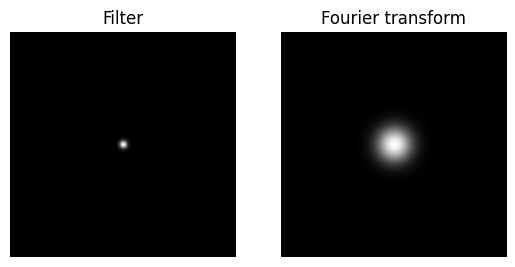

In [5]:
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Filter')
plt.imshow(np.fft.fftshift(h))

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Fourier transform')
plt.imshow(np.fft.fftshift(hF))

plt.show()

We use this short hand for the filtering.
Note that this is a symmetric operator.

In [6]:
Phi = lambda x, h: np.real(np.fft.ifft2(np.fft.fft2(x) * np.fft.fft2(h)))

We use `Phi`, and NumPy's `random` module to compute $y = \Phi f_0 + w$.

In [7]:
sigma = .02
y = Phi(f0, h) + np.random.randn(n,n) * sigma

Display.

In [8]:
snr = lambda x, y: 20 * np.log10(np.linalg.norm(x) / np.linalg.norm(x - y))

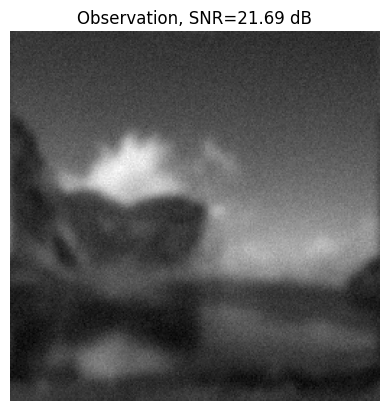

In [9]:
plt.title('Observation, SNR={:.2f} dB'.format(snr(f0, y)))
plt.axis('off')
plt.imshow(y)
plt.show()

## Deconvolution with L2 Regularization

Deconvolution without regularization is obtained by dividing the Fourier transform of $y$ by $\hat h$:
 $$f^\star(\omega) = \frac{\hat y(\omega)}{\hat h(\omega)} = \hat f_0(\omega) + \hat w(\omega)/{\hat h(\omega)}.$$
Unfortunately this creates an explosion of the Noise. To avoid this explosion, we add a simple L2 regularization:
 $$f^{\star} = \text{argmin}_f \: \|y-\Phi f\|^2 + \lambda \|f\|^2.$$
Since the filtering is diagonalized over Fourier, the solution in the Fourier domain reads
 $$\hat f^\star_k(\omega) = \frac{\hat y_k(\omega) \overline{\hat h_k(\omega)}}{ |\hat h_k(\omega)|^2 + \lambda }.$$

Fourier transform of the observation:

In [10]:
yF = np.fft.fft2(y)

We set a value for the regularization parameter:

In [11]:
Lambda = 0.02

**Question 1:** Compute $f^\star$ and display the deconvoluted image and its SNR.

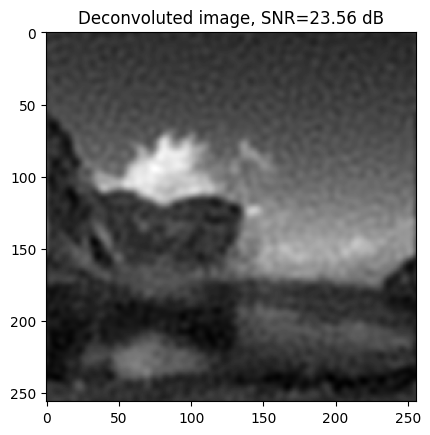

In [12]:
fF = (yF * hF) / (np.abs(hF) ** 2 + Lambda)
f = np.real(np.fft.ifft2(fF))
plt.title('Deconvoluted image, SNR={:.2f} dB'.format(snr(f0, f)))
plt.imshow(f)
plt.show()

**Question 2:** Plot the SNR for $\lambda\le 0.05$. Display the deconvoluted image obtained with the best $\lambda$.

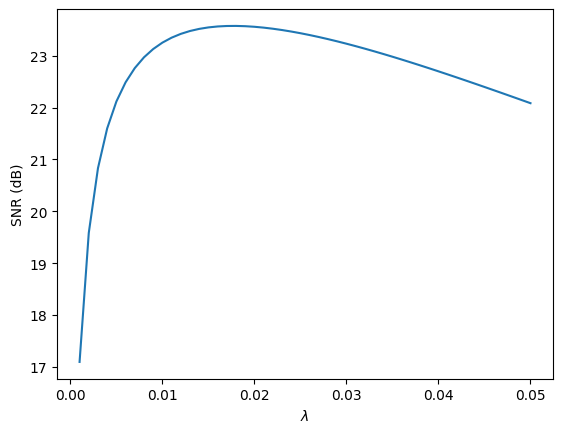

In [13]:
Lambdas = np.linspace(0.001, 0.05)
def deconvolve_L2(Lambda):
    fF = (yF * hF) / (np.abs(hF) ** 2 + Lambda)
    return np.real(np.fft.ifft2(fF))
SNRs = [snr(f0, deconvolve_L2(Lambda)) for Lambda in Lambdas]
plt.plot(Lambdas, SNRs)
plt.xlabel(r'$\lambda$')
plt.ylabel('SNR (dB)')
plt.show()

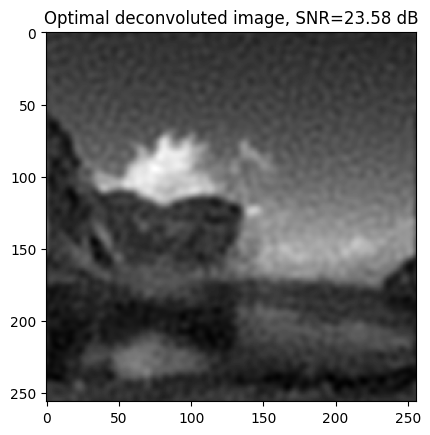

In [14]:
best_lambda = Lambdas[np.argmax(SNRs)]
plt.title('Optimal deconvoluted image, SNR={:.2f} dB'.format(snr(f0, deconvolve_L2(best_lambda))))
plt.imshow(deconvolve_L2(best_lambda))
plt.show()

## Deconvolution via Sobolev Regularization

L2 regularization did not perform any denoising. To remove some noise, we
can penalize high frequencies using Sobolev regularization. The Sobolev prior reads (note the conversion from spatial domain to Fourier domain)
 $$J(f) = \sum_x \|\nabla f(x)\|^2 = \sum_{\omega} S(\omega) \|\hat f(\omega)\|^2 $$
where $S(\omega)=\|\omega\|^2$.

Since this prior can be written over the Fourier domain, one can compute
the solution to the deblurring with Sobolev prior simply with the Fourier
coefficients:
 $$\hat f^\star(\omega) = \frac{\hat y(\omega) \overline{\hat h(\omega)}}{ \|\hat h(\omega)\|^2 + \lambda S(\omega) }$$

Recall we have a grid $X, Y$. We compute the Sobolev regularization (rescaled between 0 and 1):

In [15]:
S = (X ** 2 + Y ** 2) * (2 / n) ** 2

**Question 3:** Again, find the optimal Lambda for this method and display the best deconvoluted image.

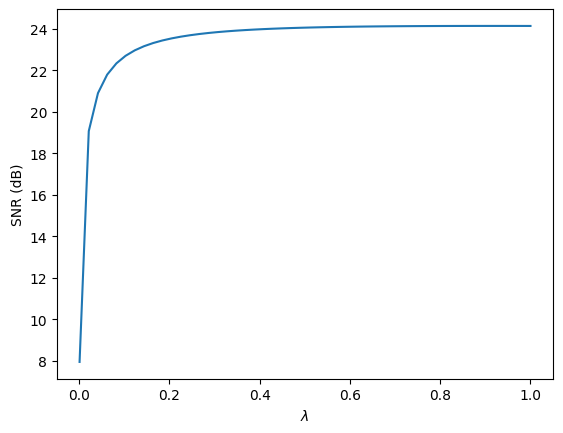

In [16]:
def deconvolve_sobolev(Lambda):
    fF = yF * hF / (hF ** 2 + Lambda * S)
    return np.real(np.fft.ifft2(fF))

Lambdas = np.linspace(0.001, 1.)
SNRs = [snr(f0, deconvolve_sobolev(Lambda)) for Lambda in Lambdas]
plt.plot(Lambdas, SNRs)
plt.xlabel(r'$\lambda$')
plt.ylabel('SNR (dB)')
plt.show()

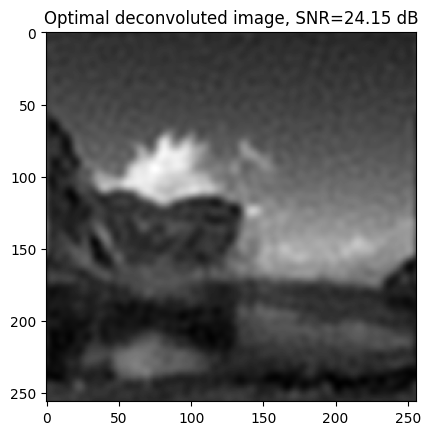

In [17]:
best_lambda = Lambdas[np.argmax(SNRs)]
plt.title('Optimal deconvoluted image, SNR={:.2f} dB'.format(snr(f0, deconvolve_sobolev(best_lambda))))
plt.imshow(deconvolve_sobolev(best_lambda))
plt.show()

## Deconvolution by Total Variation Regularization

Sobolev regularization denoises but also tends to blur the
edges, thus leading to poor results on cartoon images.

The TV prior is able to better reconstruct sharp edges. It reads:
 $$J(f) = \sum_x \| \nabla f(x)\|$$


With respect to the Sobolev energy, it simply corresponds to taking
the L1 norm instead of the L2 norm, thus dropping the square in the
functional.

Unfortunately, the TV functional $J(f)$ is not a smooth function of the image
$f$. It thus requires the use of advanced convex optimization methods to
be minimized for regularization.

An alternative is to replace the absolute value by a smooth absolute value.
The smoothed TV norm reads:
 $$J(f) = \sum_x \sqrt{\|\nabla f(x)\|^2+\varepsilon^2}$$

When $\varepsilon$ gets close to zero, the smoothed energy becomes closer to
the original total variation, but the optimization becomes more
difficult. When $\varepsilon$ becomes large, the smoothed energy becomes
closer to the Sobolev energy, thus blurring the edges.

Unfortunately, this prior is non-quadratic, and cannot be expressed over
the Fourier domain. One thus needs to use an iterative scheme such as a
gradient descent to approximate the solution.

An iteration of the gradient descent reads:
 $$f^{(k+1)} = f^{(k)} - \tau \left( h \star (h \star f^{(k)} - y) +  \lambda \text{Grad} J(f^{(k)})  \right)$$
 
The gradient of the smoothed TV energy is:
 $$\text{Grad} J(f) = -\text{div}\left( \frac{\nabla f}{ \sqrt{\|\nabla f\|^2+\varepsilon^2} } \right)$$


In [39]:
epsilon = 4e-2 # Regularization parameter for the TV norm
Lambda = 6e-1 # Regularization parameter

The value of $\tau$, the step size, should be strictly smaller than $\frac{2}{L}$, with $L$ the
Lipschitz constant of the Gradient of the functional to be minimized.

In [40]:
tau = 1.9 / (1 + Lambda * 8 / epsilon)

In order to perform the gradient descent, we need to define the discretized gradient and div.

In [41]:
def grad(f):
    s0 = np.concatenate((np.arange(1, f.shape[0]), [0]))
    s1 = np.concatenate((np.arange(1, f.shape[1]), [0]))
    return np.dstack((f[s0, :] - f, f[:, s1] - f))       # What is the shape of grad(f)? Why?

def div(g):
    s0 = np.concatenate(([g.shape[0] - 1], np.arange(0, g.shape[0] - 1)))
    s1 = np.concatenate(([g.shape[1] - 1], np.arange(0, g.shape[1] - 1)))
    return (g[:, :, 0] - g[s0, :, 0]) + (g[:, :, 1] - g[:, s1, 1])

We can check that the discretized grad and -div are adjoint one of each other.

In [42]:
a = np.random.randn(n, n)
b = np.random.randn(n, n, 2)
dotp = lambda x,y: sum(x.flatten() * y.flatten())

print("Should be 0: " + str(dotp(grad(a), b) + dotp(a, div(b))))

Should be 0: -4.320099833421409e-12


Let us start the gradient descent. First, the initialization:

In [43]:
fTV = y.copy() # initialization

**Question 4:** Compute the gradient of the smoothed TV functional $J$
 $$\text{Grad} J(f) = -\text{div}\left( \frac{\nabla f}{ \sqrt{\|\nabla f\|^2+\varepsilon^2} } \right).$$

In [44]:
g = grad(fTV)
def grad_J(g):
    division = np.sqrt(np.sum(g ** 2, axis=2) + epsilon ** 2)
    return - div(g / np.repeat(division[:, :, None], 2, axis=2))
G = grad_J(g)

**Question 5:** Compute the smoothed TV norm of $J$
 $$J(f) = \sum_x \sqrt{\|\nabla f(x)\|^2+\varepsilon^2}.$$ 

In [45]:
def J(g): # g is grad(fTV)
    TV = 0
    for x in range(g.shape[1]):
        TV += (np.linalg.norm(g[x]) ** 2 + epsilon ** 2) ** 0.5
    return TV

print('Smoothed TV norm of the image: ' + str(round(J(g), 2)))

Smoothed TV norm of the image: 170.09


**Question 6:** Implement a step of gradient descent  $$f^{(k+1)} = f^{(k)} - \tau \left( h \star (h \star f^{(k)} - y) +  \lambda \text{Grad} J(f^{(k)})  \right).$$ Recall that the convolution operator was denoted `Phi`.

In [46]:
def full_grad(fTV, Lambda=Lambda):
    g = grad(fTV)
    G = grad_J(g)
    return (Phi(h, Phi(h, fTV) - y) + Lambda * G)

fTV -= tau * full_grad(fTV)

**Question 7:** Perform the deblurring by gradient descent.
Keep track of the function being minimized: $\lVert y - f\star h\rVert^2 + \lambda J(f)$.

In [47]:
niter = 300
threshold = 1e-2
loss = []
fTV = y.copy()
g = grad(fTV)
J_val = J(g)
loss.append(0.5 * np.linalg.norm(y - Phi(fTV, h)) ** 2 + Lambda * J_val)
for i in range(niter) :
    fTV -= tau * full_grad(fTV)
    g = grad(fTV)
    J_val = J(g)
    loss.append(0.5 * np.linalg.norm(y - Phi(fTV, h)) ** 2 + Lambda * J_val)
    if loss[-2] - loss[-1] < threshold:
        print('Converged after {} iterations'.format(i))
        break

Converged after 12 iterations


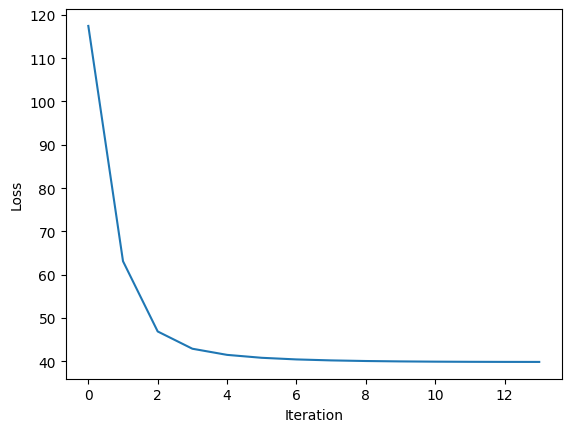

In [48]:
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.plot(loss)
plt.show()

Display the result.

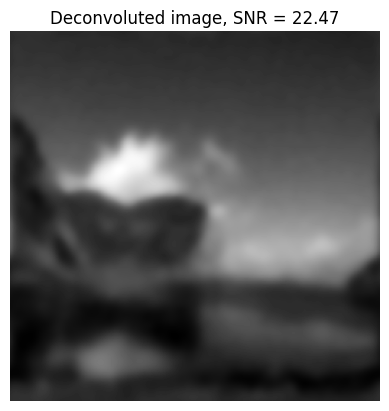

In [49]:
plt.axis('off')
plt.title('Deconvoluted image, SNR = {:.2f}'.format(snr(f0, fTV)))
plt.imshow(fTV)
plt.show()

**Question 8:** Select manually a good value for $\lambda$ and display the result.

In [50]:
def grad_descent(fTV, tau, Lambda, niter=1000, threshold=1e-2):
    loss = []
    i = 0
    g = grad(fTV)
    J_val = J(g)
    loss.append(0.5 * np.linalg.norm(y - Phi(fTV, h)) ** 2 + Lambda * J_val)
    for i in range(niter):
        fTV -= tau * full_grad(fTV, Lambda)
        g = grad(fTV)
        J_val = J(g)
        loss.append(0.5 * np.linalg.norm(y - Phi(fTV, h)) ** 2 + Lambda * J_val)
        if np.abs(loss[-1] - loss[-2]) < threshold:
            # print('converged in {} iterations'.format(i))
            break
    return fTV, loss

In [57]:
Lambdas = np.linspace(0.001, 0.005, 20)
SNRs = []
for Lambda in Lambdas:
    tau = 1.9 / (1 + Lambda * 8 / epsilon)
    fTV = y.copy()
    fTV, _ = grad_descent(fTV, tau, Lambda, niter=400)
    SNRs.append(snr(f0, fTV))

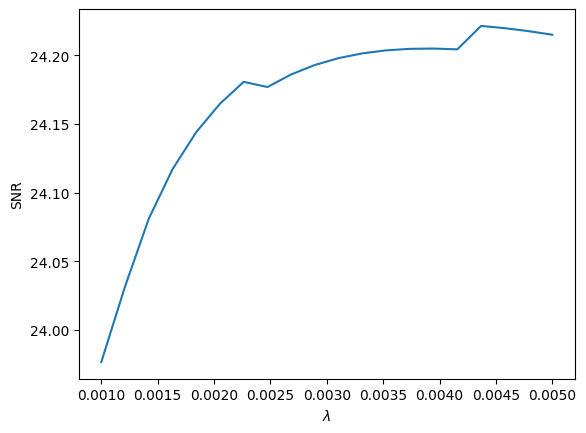

In [58]:
plt.ylabel('SNR')
plt.xlabel(r'$\lambda$')
plt.plot(Lambdas, SNRs)
plt.show()

Display the result.

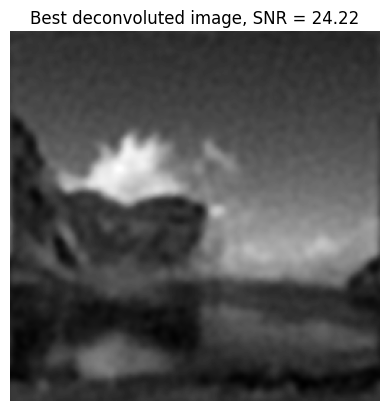

In [59]:
best_lambda = Lambdas[np.argmax(SNRs)]
tau = 1.9 / (1 + best_lambda * 8 / epsilon)
fTV = y.copy()
fTV, _ = grad_descent(fTV, tau, best_lambda, niter=400)

plt.axis('off')
plt.title('Best deconvoluted image, SNR = {:.2f}'.format(snr(f0, fTV)))
plt.imshow(fTV)
plt.show()